In [27]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16, vgg19
from keras import backend as K
import numpy as np
import time
import glob
import imageio
from scipy.optimize import fmin_l_bfgs_b
from itertools import combinations

from scipy.misc import imread, imresize, imsave, fromimage, toimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
base_image_path = 'style_transfer/Okerk2.jpg'
style1_image_path = 'style_transfer/water-lilies-1919-2.jpg'
style2_image_path = 'style_transfer/VanGogh-starry_night_ballance1.jpg'


In [3]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess_image(image_path, target_size=None):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x, w, h):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, w, h))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((w, h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
w, h = 740, 468
style_image = K.variable(preprocess_image(style1_image_path, target_size=(h, w)))
result_image = K.placeholder(style_image.shape)
input_tensor = K.concatenate([style_image,
                              result_image], axis=0)
input_tensor.shape

TensorShape([Dimension(2), Dimension(468), Dimension(740), Dimension(3)])

In [5]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [6]:
class Evaluator(object):
    def __init__(self, loss_total, result_image, **other):
        grads = K.gradients(loss_total, result_image)
        outputs = [loss_total] + list(other.values()) + grads
        self.iterate = K.function([result_image], outputs)
        self.other = list(other.keys())
        self.other_values = {}
        self.shape = result_image.shape

        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        outs = self.iterate([x.reshape(self.shape)])
        self.loss_value = outs[0]
        self.grad_values = outs[-1].flatten().astype('float64')
        self.other_values = dict(zip(self.other, outs[1:-1]))
        return self.loss_value

    def grads(self, x):
        return np.copy(self.grad_values)

In [7]:
def gram_matrix(x):
    if K.image_data_format() != 'channels_first':
        x = K.permute_dimensions(x, (2, 0, 1))
    features = K.batch_flatten(x)
    return K.dot(features - 1, K.transpose(features - 1)) - 1

def style_loss(layer_1, layer_2):
    gr1 = gram_matrix(layer_1)
    gr2 = gram_matrix(layer_2)
    return K.sum(K.square(gr1 - gr2)) / (np.prod(layer_2.shape).value ** 2)

In [8]:
feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]

loss_style = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style += style_loss(layer_features[0, :, :, :], layer_features[1, :, :, :])

style_evaluator = Evaluator(loss_style, result_image)

In [9]:
def run(evaluator, image, num_iter=25):
    for i in range(num_iter):
        start_time = time.time()

        image, min_val, info = fmin_l_bfgs_b(evaluator.loss, image.flatten(), fprime=evaluator.grads, maxfun=20)

        end_time = time.time()
        clear_output()
        showarray(deprocess_image(image.copy(), h, w))

        print("Iteration %d completed in %ds" % (i + 1, end_time - start_time))
        print("Current loss value:", min_val)
        print(' '.join(k + ':' + str(evaluator.other_values[k]) for k in evaluator.other))
    return image

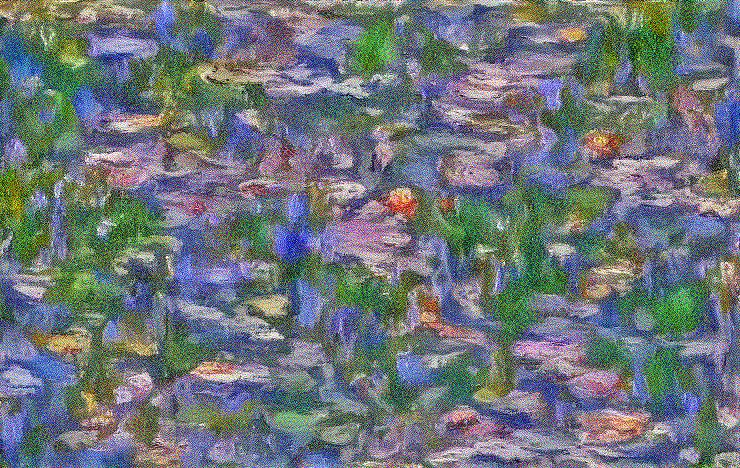

Iteration 50 completed in 8s
Current loss value: 6.99779e+06



In [10]:
x = np.random.uniform(0, 255, result_image.shape) - 128.
res = run(style_evaluator, x, num_iter=50)

In [11]:
def total_variation_loss(x, exp=1.25):
    _, d1, d2, d3 = x.shape
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :d2 - 1, :d3 - 1] - x[:, :, 1:, :d3 - 1])
        b = K.square(x[:, :, :d2 - 1, :d3 - 1] - x[:, :, :d2 - 1, 1:])
    else:
        a = K.square(x[:, :d1 - 1, :d2 - 1, :] - x[:, 1:, :d2 - 1, :])
        b = K.square(x[:, :d1 - 1, :d2 - 1, :] - x[:, :d1 - 1, 1:, :])
    return K.sum(K.pow(a + b, exp))

In [12]:
loss_variation = total_variation_loss(result_image) / 5000

loss_with_variation = loss_variation + loss_style

evaluator_with_variation = Evaluator(loss_with_variation, result_image)

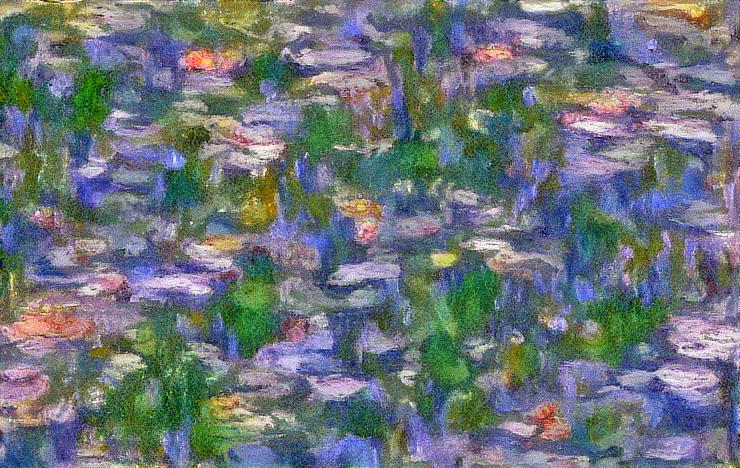

Iteration 100 completed in 7s
Current loss value: 7.76641e+06



In [13]:
x = np.random.uniform(0, 255, result_image.shape) - 128.
res = run(evaluator_with_variation, x, num_iter=100)

In [14]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [15]:
w, h = load_img(base_image_path).size
base_image = K.variable(preprocess_image(base_image_path))
style_image = K.variable(preprocess_image(style2_image_path, target_size=(h, w)))
combination_image = K.placeholder(style_image.shape)
input_tensor = K.concatenate([base_image,
                              style_image,
                              combination_image], axis=0)

In [16]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [17]:
feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]

loss_content = content_loss(feature_outputs[-1][0, :, :, :],
                            feature_outputs[-1][2, :, :, :])
loss_variation = total_variation_loss(combination_image)
loss_style = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style += style_loss(layer_features[1, :, :, :], layer_features[2, :, :, :]) * (0.5 ** idx)

loss_content /= 40
loss_variation /= 10000

loss_total = loss_content + loss_variation + loss_style

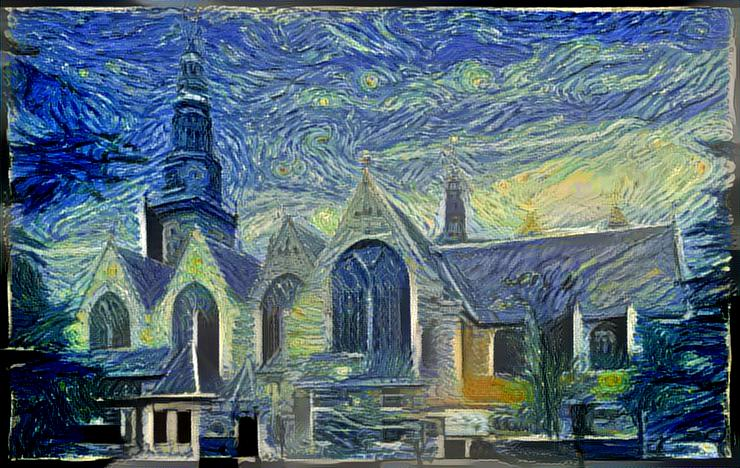

Iteration 100 completed in 9s
Current loss value: 1.22668e+06
loss_content:131194.0 loss_variation:835965.0 loss_style:259524.0


array([ -86.67183856, -102.50101875, -120.60053996, ...,  -79.63784924,
       -122.8846842 , -135.86743068])

In [18]:
combined_evaluator = Evaluator(loss_total, combination_image, loss_content=loss_content, 
                               loss_variation=loss_variation, loss_style=loss_style)
run(combined_evaluator, preprocess_image(base_image_path), num_iter=100)

In [19]:
w, h = load_img(base_image_path).size
base_image = K.variable(preprocess_image(base_image_path))
winter_style_image = K.variable(preprocess_image('style_transfer/road-to-versailles-at-louveciennes.jpg',
                                                 target_size=(h, w)))
summer_style_image = K.variable(preprocess_image('style_transfer/VanGogh_Farmhouse.jpeg', target_size=(h, w)))
combination_image = K.placeholder(summer_style_image.shape)
input_tensor = K.concatenate([base_image,
                              summer_style_image,
                              winter_style_image,
                              combination_image], axis=0)

In [20]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [21]:
feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]

loss_content = content_loss(feature_outputs[-1][0, :, :, :],
                            feature_outputs[-1][2, :, :, :])
loss_variation = total_variation_loss(combination_image)

loss_style_summer = K.variable(0.)
loss_style_winter = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style_summer += style_loss(layer_features[1, :, :, :], layer_features[-1, :, :, :]) * (0.5 ** idx)
    loss_style_winter += style_loss(layer_features[2, :, :, :], layer_features[-1, :, :, :]) * (0.5 ** idx)

loss_content /= 40
loss_variation /= 10000

summerness = K.placeholder()
loss_total = (loss_content + loss_variation + 
              loss_style_summer * summerness + 
              loss_style_winter * (1 - summerness))

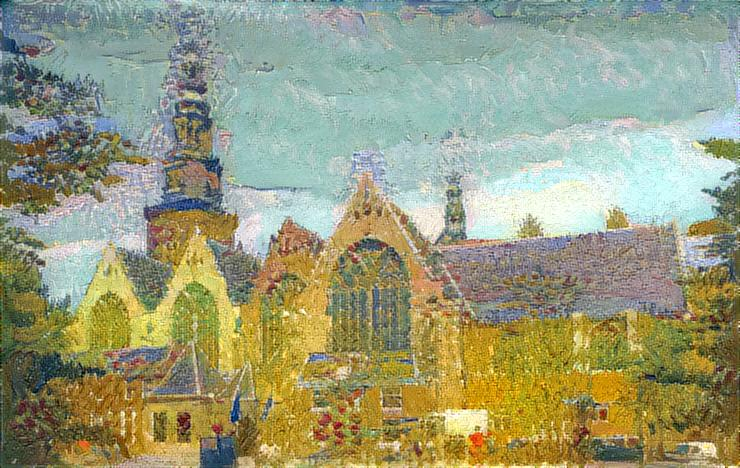

Iteration 50 completed in 14s
Current loss value: 1.53012e+06
loss_content:977339.0 loss_variation:478013.0 loss_style_winter:6.99553e+08 loss_style_summer:74765.8


In [22]:
combined_evaluator = Evaluator(loss_total, combination_image, loss_content=loss_content, 
                               loss_variation=loss_variation, loss_style_summer=loss_style_summer,
                               loss_style_winter=loss_style_winter)
iterate = K.function([combination_image, summerness], 
                     combined_evaluator.iterate.outputs)

combined_evaluator.iterate = lambda inputs: iterate(inputs + [1.0])
res = run(combined_evaluator, preprocess_image(base_image_path), num_iter=50)

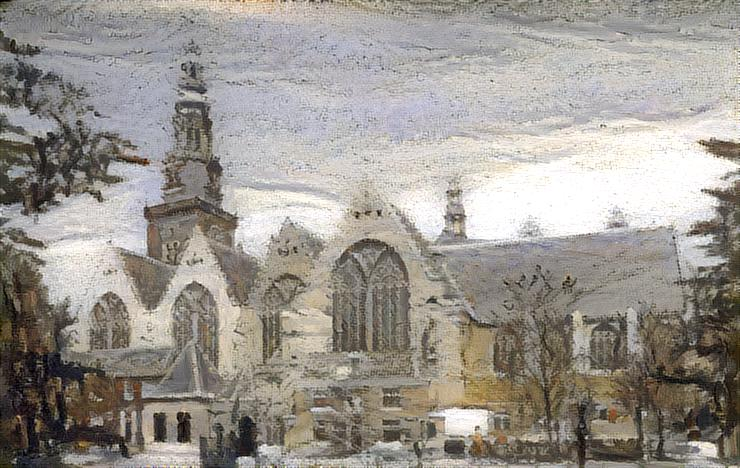

Iteration 50 completed in 14s
Current loss value: 1.38132e+06
loss_content:977339.0 loss_variation:359193.0 loss_style_winter:44786.7 loss_style_summer:6.99701e+08


In [24]:
path = 'style_transfer/summer_winter_%d.jpg'
def save(res, step):
    img = deprocess_image(res.copy(), h, w)
    imsave(path % step, img)

for step in range(1, 21):
    combined_evaluator = Evaluator(loss_total, combination_image, loss_content=loss_content, 
                                   loss_variation=loss_variation, loss_style_summer=loss_style_summer,
                                   loss_style_winter=loss_style_winter)
    iterate = K.function([combination_image, summerness], 
                         combined_evaluator.iterate.outputs)

    combined_evaluator.iterate = lambda inputs: iterate(inputs + [1.0 - step / 20.])
    res = run(combined_evaluator, preprocess_image(base_image_path), num_iter=50)
    save(res, step)

In [28]:
frames = glob.glob('style_transfer/summer_winter_*.jpg')
frames = sorted(frames, key=lambda f:int(f.split('.', 1)[0].rsplit('_', 1)[-1]))
cycled = frames + list(reversed(frames[1:-1]))
# Save them as frames into a gif 
kargs = { 'duration': 0.1 }
imageio.mimsave('style_transfer/animated.gif', [imageio.imread(x) for x in cycled], 'GIF', **kargs)

HTML('<img src="style_transfer/animated.gif">')